In [1]:
import cvxpy as cp
import scipy as sp
from scipy.special import roots_sh_legendre
from scipy.sparse import csr_array
from scipy.linalg import expm
import numpy as np
import matplotlib.pyplot as plt
import bisect

In [2]:
class SiteBasis:
    def __init__(self, N):
        self._N = N
        # self._ops = 'IXYZ'
        self._ops = self.gen_basis()
        self._ops.sort()
        self._opset = set(self._ops)
   
    def full_rank(self, word):
        r = 0
        for i, op in enumerate(reversed(word)):
            if op not in 'IXYZ':
                raise ValueError(f'{word} must have only IXYZ')
            r += (4 ** i) * ('IXYZ'.find(op))
        return r

    def full_unrank(self, pos):
        word = [None] * self._N
        for i in range(self._N):
            word[i] = 'IXYZ'[pos % 4]
            pos //= 4
        return ''.join(word[::-1])

    def enforce_rotation(self):
        exclude = set()
        L = self._N
        for i in range(4 ** L):
            if i in exclude:
                continue
            op = self.full_unrank(i)
            op2 = op
            for j in range(L - 1):
                op = op[1:] + op[0]
                if op == op2:
                    break
                exclude.add(self.full_rank(op))
        small_basis = []
        for i in range(4 ** L):
            if i in exclude:
                continue
            small_basis.append(self.full_unrank(i))
        return small_basis

    def enforce_reflection(self, basis):
        exclude = set()
        bset = set(basis)
        for word in bset:
            if word in exclude:
                continue
            rword = word[::-1]
            if word == rword:
                continue
            if rword not in bset:
                rword2 = rword[1:] + rword[0]
                while rword2 not in bset:
                    if rword2 == rword:
                        break
                    rword2 = rword2[1:] + rword2[0]
                if word != rword2:
                    exclude.add(rword2)
            else:
                exclude.add(rword)
        smaller_basis = []
        for word in basis:
            if word in exclude:
                continue
            smaller_basis.append(word)
        return smaller_basis

    def gen_basis(self):
        small_basis = self.enforce_rotation()
        return self.enforce_reflection(small_basis)
    
    def size(self):
        return len(self._ops)
    
    def rank(self, word: str):
        if len(word) != self._N:
            raise ValueError(f'{word} must be of length {self._N}')
        if word not in self._opset:
            word = self.normalize(word)
        return bisect.bisect_left(self._ops, word)

    def unrank(self, pos: int):
        word = self.full_unrank(pos)
        return self._ops[self.rank(word)]

    def normalize(self, word):
        if len(word) != self._N:
            raise ValueError(f'{word} must be of length {self._N}')
        if word not in self._opset:
            word2 = word[1:] + word[0]
            while word2 not in self._opset:
                if word2 == word:
                    return self.normalize(word[::-1])
                word2 = word2[1:] + word2[0]
            return word2
        return word

def basis_commutator(o1, o2):
    commutation_table = [
        [(0, ''),(0, ''),(0, ''),(0, '')],
        [(0, ''),(0, ''),(2j, 'Z'),(-2j, 'Y')],
        [(0, ''),(-2j, 'Z'),(0, ''),(2j, 'X')],
        [(0, ''),(2j, 'Y'),(-2j, 'X'),(0, '')],
    ]
    return commutation_table['IXYZ'.find(o1)]['IXYZ'.find(o2)]

def basis_anticommutator(o1, o2):
    anticommutation_table = [
        [(2, 'I'),(2, 'X'),(2, 'Y'),(2, 'Z')],
        [(2, 'X'),(2, 'I'),(0, ''),(0, '')],
        [(2, 'Y'),(0, ''),(2, 'I'),(0, '')],
        [(2, 'Z'),(0, ''),(0, ''),(2, 'I')],
    ]
    return anticommutation_table['IXYZ'.find(o1)]['IXYZ'.find(o2)]

def basis_product(o1, o2):
    product_table = [
        [(1, 'I'),(1, 'X'),(1, 'Y'),(1, 'Z')],
        [(1, 'X'),(1, 'I'),(1j, 'Z'),(-1j, 'Y')],
        [(1, 'Y'),(-1j, 'Z'),(1, 'I'),(1j, 'X')],
        [(1, 'Z'),(1j, 'Y'),(-1j, 'X'),(1, 'I')],
    ]
    return product_table['IXYZ'.find(o1)]['IXYZ'.find(o2)]

def anticommutator(word1, word2):
    if len(word1) != len(word2):
        raise ValueError(f'{word1} and {word2} do not have same length')
    if len(word1) == 1:
        return [basis_anticommutator(word1, word2)]
    expression = []
    e_1 = commutator(word1[0],word2[0])
    e_2 = commutator(word1[1:], word2[1:])
    e_3 = anticommutator(word1[0], word2[0])
    e_4 = anticommutator(word1[1:],word2[1:])
    for c1, o1 in e_1:
        for c2, o2 in e_2:
            expression.append((0.5 * c1 * c2, o1 + o2))
    for c1, o1 in e_3:
        for c2, o2 in e_4:
            expression.append((0.5 * c1 * c2, o1 + o2))
    return expression

def commutator(word1: str, word2: str):
    if len(word1) != len(word2):
        raise ValueError(f'{word1} and {word2} do not have same length')
    if len(word1) == 1:
        return [basis_commutator(word1, word2)]
    expression = []
    e_1 = commutator(word1[0],word2[0])
    e_2 = anticommutator(word1[1:], word2[1:])
    e_3 = anticommutator(word1[0], word2[0])
    e_4 = commutator(word1[1:],word2[1:])
    for c1, o1 in e_1:
        for c2, o2 in e_2:
            expression.append((0.5 * c1 * c2, o1 + o2))
    for c1, o1 in e_3:
        for c2, o2 in e_4:
            expression.append((0.5 * c1 * c2, o1 + o2))
    return expression

def product(word1, word2):
    if len(word1) != len(word2):
        raise ValueError(f'{word1} and {word2} do not have same length')
    word = []
    coeff = 1
    for o1, o2 in zip(word1, word2):
        c, op = basis_product(o1, o2)
        word.append(op)
        coeff *= c
    return (coeff, ''.join(word))

<h2>Thermal Transverse Field Ising:</h2>

In [3]:
def schwinger_dyson(hamil: list, word1: str):
    expression = []
    for coeff, w in hamil:
        terms = commutator(w, word1)
        for c, op in terms:
            if len(op) != len(word1):
                continue
            if not np.isclose(np.abs(coeff * c), 0):
                expression.append((op, coeff * c))
    return expression

def normalization(basis, L, B):
    return [B[basis.rank('I'*L)] == 1]

In [9]:
L = 2
h = 1
basis = SiteBasis(L)
hamil = []
for i in range(L):
    t1 = None
    if i<L-1:
        t1 = 'I'*i + 'XX' + 'I'*(L-i-2)
    else:
        t1 = 'X' + 'I'*(L-2) + 'X'
    t2 = 'I'*i+'Z'+'I'*(L-i-1)
    hamil.extend([(-1, t1), (-h, t2)])
if L == 2:
    hamil = [(-h, 'IZ'), (-h, 'ZI'), (-1, 'XX')]
# print(hamil)
ops = basis._ops
def get_C_term(i, j):
    expression = []
    for coeff, w in hamil:
        terms = commutator(w, ops[j])
        for c, op in terms:
            if len(op) != len(w):
                continue
            c2, op2 = product(ops[i], op)
            # expression = expression + coeff * c * c2 * H[basis.rank(op2)]
            expression.append((coeff * c * c2, op2))
    return expression
def get_A_term(i, j):
    coeff, word = product(ops[i], ops[j])
    return coeff, word
check = set(basis._ops)
for i in range(basis.size()):
    for j in range(basis.size()):
        _,terms = get_A_term(i,j)
        # for _,word in terms:
        check.discard(terms)
print(check)

set()


In [5]:
def beta_independent_constraints(basis, B, L, hamil):
    constraints = []
    constraints.extend(normalization(basis, L, B))
    row_ind, col_ind, data = [], [], []
    numc = 0
    n = basis.size()
    def add_terms(terms):
        nonlocal numc
        new_row = 0
        cnt = 0
        for term in terms:
            cnt += 1
            new_row = 1
            col_ind.append(basis.rank(term[0]))
            data.append(term[1])
            row_ind.append(numc)
        numc += new_row
    for word in basis._ops:
        add_terms(schwinger_dyson(hamil, word))
    if len(col_ind) > 0:
        P = csr_array((data, (row_ind, col_ind)), (numc, n))
        constraints.append(P @ B == 0)
    return constraints

def beta_independent_kms_constraints_mod(basis, H, k, hamil):
    ops = basis._ops
    n = len(ops)
    constraints = []
    def get_A_term(i, j):
        coeff, word = product(ops[i], ops[j])
        return coeff * H[basis.rank(word)]
    A = cp.bmat([[get_A_term(i, j) for j in range(n)] for i in range(n)])
    Zs = [cp.Variable((n,n),f'Z_{i}',hermitian=True) for i in range(0, k + 1)]
    T = cp.Variable((n,n),'T',hermitian=True)
    constraints.append(Zs[0] == cp.transpose(A))
    for i in range(k):
        constraints.append(cp.bmat([[Zs[i], Zs[i+1]],
                                    [Zs[i+1], A]]) >> 0)
    # constraints.append(cp.bmat([[Zs[k] - A - T, -np.sqrt(3) * T],
    #                             [-np.sqrt(3) * T, Zs[k] + 5 * A - 3 * T]]) >> 0)
    def get_C_term(i, j):
        expression = 0
        for coeff, w in hamil:
            terms = commutator(w, ops[j])
            for c, op in terms:
                if len(op) != len(w):
                    continue
                c2, op2 = product(ops[i], op)
                expression = expression + coeff * c * c2 * H[basis.rank(op2)]
        return expression
    C = cp.bmat([[get_C_term(i, j) for j in range(n)] for i in range(n)])
    return T, C, Zs, A, constraints

def beta_dependent_kms_constraints_mod(T, C, Zs, A, k, beta):
    constraints = []
    constraints.append(T == -2**(-k) * beta * C)
    constraints.append(-T + 0.01*Zs[k] + 5 * A >> 0)
    return constraints

def test_kms(basis, H, hamil, beta, k):
    ops = basis._ops
    n = len(ops)
    constraints = []
    def get_A_term(i, j):
        coeff, word = product(ops[i], ops[j])
        return coeff * H[basis.rank(word)]
    A = cp.bmat([[get_A_term(i, j) for j in range(n)] for i in range(n)])
    def get_C_term(i, j):
        expression = 0
        for coeff, w in hamil:
            terms = commutator(w, ops[j])
            for c, op in terms:
                if len(op) != len(w):
                    continue
                c2, op2 = product(ops[i], op)
                expression = expression + coeff * c * c2 * H[basis.rank(op2)]
        return expression
    C = cp.bmat([[get_C_term(i, j) for j in range(n)] for i in range(n)])
    T = 2**(-k) * beta * C
    B = cp.conj(A)
    Zs = [B] + [cp.Variable((n,n),f'Z_{i}',hermitian=True) for i in range(1, k + 1)]
    for i in range(k):
        constraints.append(cp.bmat([[Zs[i], Zs[i+1]],
                                    [Zs[i+1], A]]) >> 0)
    constraints.append(cp.bmat([[Zs[k] - A + T, np.sqrt(3) * T],
                                [np.sqrt(3) * T, Zs[k] + 5 * A + 3 * T]]) >> 0)
    # a, b = -0.4, 10.1
    # constraints.append(cp.bmat([[Zs[k] -(1 - a) * A + T - b * A , np.sqrt(3) * T],
    #                             [np.sqrt(3) * T, Zs[k] + (5 + a) * A + 3 * T - 3 * b * A]]) >> 0)
    # control_points = [0.001, 0.01,0.1,10]
    # for p in control_points:
    #     constraints.append(T+(1/p) * B + (np.log(p) - 1) * A >> 0)
    return constraints

In [6]:
def solve_energy(betas, h, L, k):
    basis = SiteBasis(L)
    B = cp.Variable(basis.size())
    beta = cp.Parameter(nonneg = True)
    hamil = []
    for i in range(L):
        t1 = None
        if i<L-1:
            t1 = 'I'*i + 'XX' + 'I'*(L-i-2)
        else:
            t1 = 'X' + 'I'*(L-2) + 'X'
        t2 = 'I'*i+'Z'+'I'*(L-i-1)
        hamil.extend([(-1, t1), (-h, t2)])
    if L == 2:
        hamil = [(-h, 'IZ'), (-h, 'ZI'), (-1, 'XX')]
    constraints = beta_independent_constraints(basis, B, L, hamil)
    constraints.extend(test_kms(basis, B, hamil, beta, k))
    # Ts, C, Zs, A, extra_constraints = beta_independent_kms_constraints_mod(basis, B, k, hamil)
    # constraints.extend(extra_constraints)
    # kms_constraints = beta_dependent_kms_constraints_mod(Ts, C, Zs, A, k, beta)
    # constraints.extend(kms_constraints)
    mins,maxs,Bmins,Bmaxs = [], [], [], []
    energy = sum(c * B[basis.rank(op)] for c, op in hamil)
    minprob = cp.Problem(cp.Minimize(energy), constraints)
    maxprob = cp.Problem(cp.Maximize(energy), constraints)
    for i, val in enumerate(betas, 1):
        beta.value = val
        print(f'Solving for T={1/val}, i={i}:')
        E_min = minprob.solve(verbose=True,accept_unknown=True)
        Bmins.append(B.value)
        E_max = maxprob.solve(accept_unknown=True)
        Bmaxs.append(B.value)
        print(f'\tE_min = {E_min}')
        print(f'\tE_max = {E_max}')
        mins.append(E_min)
        maxs.append(E_max)
    return mins, maxs, Bmins, Bmaxs

In [7]:
h = 1
L = 2
Jx = 1

I = np.array([[1,0],[0,1]],dtype=np.complex128)
X = np.array([[0,1],[1,0]],dtype=np.complex128)
Y = np.array([[0,-1j],[1j,0]],dtype=np.complex128)
Z = np.array([[1,0],[0,-1]],dtype=np.complex128)
Hs = [-h*(np.kron(Z,I)+np.kron(I,Z))-Jx*(np.kron(X,X)),
      -h*(np.kron(Z,np.kron(I,I))+np.kron(I,np.kron(Z,I))+np.kron(I,np.kron(I,Z)))-Jx*(np.kron(X,np.kron(X,I))+np.kron(I,np.kron(X,X))+np.kron(X,np.kron(I,X))),
      -h*(np.kron(Z,np.kron(I,np.kron(I,I)))+np.kron(I,np.kron(Z,np.kron(I,I)))+np.kron(I,np.kron(I,np.kron(Z,I)))+np.kron(I,np.kron(I,np.kron(I,Z))))-Jx*(np.kron(X,np.kron(X,np.kron(I,I)))+np.kron(I,np.kron(X,np.kron(X,I)))+np.kron(I,np.kron(I,np.kron(X,X)))+np.kron(X,np.kron(I,np.kron(I,X))))]
H = Hs[L - 2]

Z=np.zeros(1000)
expZ=np.zeros(1000)
expXX=np.zeros(1000)
Temp=np.linspace(0.01,4,num=1000)
beta=1/Temp
sigZ = np.array([[1,0],[0,-1]],dtype=np.complex128)
for i in range(1000):
    P = expm(-beta[i] * H)
    Z[i] = np.trace(P)
    rho = P / Z[i]
    expZ[i]=np.trace(np.dot(rho,np.kron(sigZ,I)+np.kron(I,sigZ)))
    expXX[i]=np.trace(np.dot(rho,np.kron(X,X)))
    # expZ[i]=np.trace(np.dot(rho,np.kron(sigZ,np.kron(I,I))+np.kron(I,np.kron(sigZ,I))+np.kron(I,np.kron(I,sigZ))))
    # expXX[i]=np.trace(np.dot(rho,np.kron(np.kron(X,X),I)+np.kron(np.kron(X,I),X)+np.kron(I,np.kron(X,X))))
Energy=np.gradient(-np.log(Z),beta)
Cv=np.gradient(Energy,Temp)

/tmp/ipykernel_855/4099401611.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  Z[i] = np.trace(P)
/tmp/ipykernel_855/4099401611.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  expZ[i]=np.trace(np.dot(rho,np.kron(sigZ,I)+np.kron(I,sigZ)))
/tmp/ipykernel_855/4099401611.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  expXX[i]=np.trace(np.dot(rho,np.kron(X,X)))


In [8]:
betas = 1/np.linspace(0.01, 4, num = 20)
k = 0
# h, L = 1, 3
print(SiteBasis(L).size())

10


In [9]:
mins, maxs, Bmins, Bmaxs = solve_energy(betas, h, L, k)

Solving for T=0.01, i=1:
                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Oct 26 01:38:04 AM: Your problem has 10 variables, 809 constraints, and 1 parameters.
(CVXPY) Oct 26 01:38:04 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 26 01:38:04 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 26 01:38:04 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 26 01:38:04 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Oct 26 01:38:04 AM: Reduction chain: Complex2Real -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

/home/mainak/mtp/my-work/.venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #3 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/mainak/mtp/my-work/.venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #4 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


(CVXPY) Oct 26 01:38:06 AM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 26 01:38:06 AM: Applying reduction ConeMatrixStuffing
(CVXPY) Oct 26 01:38:07 AM: Applying reduction MOSEK
(CVXPY) Oct 26 01:38:07 AM: Finished problem compilation (took 2.603e+00 seconds).
(CVXPY) Oct 26 01:38:07 AM: (Subsequent compilations of this problem, using the same arguments, should take less time.)
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Oct 26 01:38:07 AM: Invoking solver MOSEK  to obtain a solution.


(CVXPY) Oct 26 01:38:07 AM: Problem
(CVXPY) Oct 26 01:38:07 AM:   Name                   :                 
(CVXPY) Oct 26 01:38:07 AM:   Objective sense        : maximize        
(CVXPY) Oct 26 01:38:07 AM:   Type                   : CONIC (conic optimization problem)
(CVXPY) Oct 26 01:38:07 AM:   C

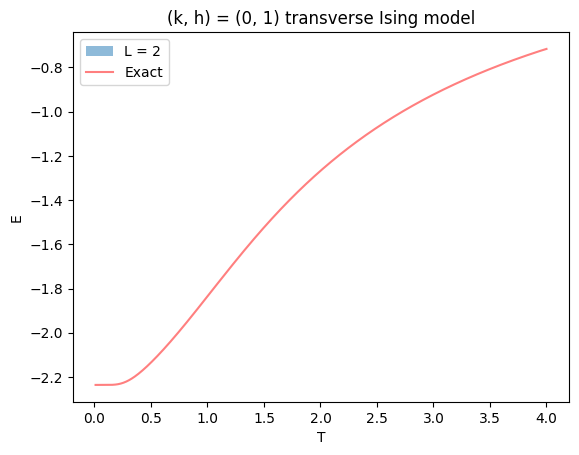

In [10]:
plt.fill_between(1/betas, mins, maxs, alpha = 0.5, label=f'L = {L}')
plt.plot(1/betas, mins,c ='red',linestyle='--')
plt.plot(1/betas, maxs,c ='blue',linestyle='--')
plt.plot(Temp, Energy, alpha=0.5, label='Exact', c='red')
# plt.xlim(0.0,0.5)
# plt.ylim(-2.0,-2.5)
plt.xlabel('T')
plt.ylabel('E')
plt.title(f'(k, h) = ({k}, {h}) transverse Ising model')
plt.legend()
plt.show()

In [11]:
# w = 'XY'
Z0mins = [V[SiteBasis(L).rank(w)] for V in Bmins]
Z0maxs = [V[SiteBasis(L).rank(w)] for V in Bmaxs]
plt.fill_between(1/betas, Z0mins, Z0maxs, alpha = 0.5, label=f'L = {L}')
plt.plot(1/betas, Z0mins,c ='red',linestyle='--')
plt.plot(1/betas, Z0maxs,c ='blue',linestyle='--')
# plt.plot(Temp, expXX, alpha=0.5, label='Exact', c='red')
plt.xlabel('T')
plt.ylabel('<Z0>')
plt.title(f'(k, h) = ({k}, {h}) transverse Ising')
plt.legend()
plt.show()

NameError: name 'w' is not defined

In [93]:
# basis = SiteBasis(L)
# cnt = 0
# bad = set()
# for i in range(basis.size()):
#     Z0mins = [V[i] for V in Bmins]
#     Z0maxs = [V[i] for V in Bmaxs]
#     if np.allclose(Z0mins, 0) and np.allclose(Z0maxs, 0):
#         bad.add(basis.unrank(i))
# print(len(bad), basis.size())
# print(bad)

In [94]:
# plt.fill_between(1/betas, np.gradient(mins, 1/betas), np.gradient(maxs, 1/betas), alpha = 0.5, label=f'L = {L}')
# plt.plot(1/betas, np.gradient(mins, 1/betas),c ='red',linestyle='--')
# plt.plot(1/betas, np.gradient(maxs, 1/betas),c ='blue',linestyle='--')
# plt.plot(Temp, Cv, label='Exact', c='red', alpha=0.5)
# plt.xlabel('T')
# plt.ylabel('Cv')
# plt.title(f'(k, h) = ({k}, {h}) transverse Ising model')
# plt.legend()
# plt.show()

In [95]:
# XXmins = [V[SiteBasis(L).rank('XXI')] for V in Bmins]
# XXmaxs = [V[SiteBasis(L).rank('XXI')] for V in Bmaxs]
# plt.fill_between(1/betas, XXmins, XXmaxs, alpha = 0.5, label=f'L = {L}')
# plt.plot(1/betas, XXmins,c ='red',linestyle='--')
# plt.plot(1/betas, XXmaxs,c ='blue',linestyle='--')
# plt.plot(Temp, expXX/3, alpha=0.5, label='Exact', c='red')
# plt.xlabel('T')
# plt.ylabel('<XX>')
# plt.title(f'(m, k, h, nc, nm) = ({m}, {k}, {h}, {nc}, {nm}) transverse Ising')
# plt.legend()
# plt.show()

In [96]:
# def solve_Z(betas, h, L, m, k, nc, nm):
#     basis = SiteBasis(L)
#     B = cp.Variable(4**L)
#     beta = cp.Parameter(nonneg = True)
#     hamil = []
#     for i in range(L):
#         t1 = None
#         if i<L-1:
#             t1 = 'I'*i + 'XX' + 'I'*(L-i-2)
#         else:
#             t1 = 'X' + 'I'*(L-2) + 'X'
#         t2 = 'I'*i+'Z'+'I'*(L-i-1)
#         hamil.extend([(-1, t1), (-h, t2)])
#     if L == 2:
#         hamil = [(-h, 'IZ'), (-h, 'ZI'), (-1, 'XX')]
#     constraints = beta_independent_constraints(basis, B, L, hamil, nm)
#     Ts, C, extra_constraints = beta_independent_kms_constraints(basis, B, nc, L, m, k, hamil)
#     constraints.extend(extra_constraints)
#     kms_constraints = beta_dependent_kms_constraints(Ts, C, m, k, beta)
#     constraints.extend(kms_constraints)
#     mins,maxs,Zmins,Zmaxs = [], [], [], []
#     energy = sum(c * B[basis.rank(op)] for c, op in hamil)
#     minE = cp.Problem(cp.Minimize(energy), constraints)
#     maxE = cp.Problem(cp.Maximize(energy), constraints)
#     for i, val in enumerate(betas, 1):
#         beta.value = val
#         print(f'Solving for T={1/val}, i={i}:')
#         E_min = minE.solve(accept_unknown=True)
#         # Bmins.append(B.value)
#         E_max = maxE.solve(accept_unknown=True)
#         # Bmaxs.append(B.value)
#         minZ = cp.Problem(cp.Minimize(B[basis.rank('Z'+'I'*(L-1))]), constraints + [E_min <= energy, energy <= E_max])
#         maxZ = cp.Problem(cp.Minimize(B[basis.rank('Z'+'I'*(L-1))]), constraints + [E_min <= energy, energy <= E_max])
#         Z_min = minZ.solve(accept_unknown=True)
#         Z_max = maxZ.solve(accept_unknown=True)
#         print(f'\tE_min = {E_min}')
#         print(f'\tE_max = {E_max}')
#         print(f'\tZ_min = {Z_min}')
#         print(f'\tZ_max = {Z_max}')
#         mins.append(E_min)
#         maxs.append(E_max)
#         Zmins.append(Z_min)
#         Zmaxs.append(Z_max)
#     return mins, maxs, Zmins, Zmaxs

In [97]:
# betas = 1/np.linspace(0.01, 4, num = 20)
# m, k, nc, nm = 2, 2, 6, 0
# print(nc)
# print(gen_basis(L))

In [98]:
# mins, maxs, Zmins, Zmaxs = solve_Z(betas, h, 2, m, k, nc, nm)

In [99]:
# plt.fill_between(1/betas, mins, maxs, alpha = 0.5, label=f'L = {2}')
# plt.plot(1/betas, mins,c ='red',linestyle='--')
# plt.plot(1/betas, maxs,c ='blue',linestyle='--')
# plt.plot(Temp, Energy, alpha=0.5, label='Exact', c='red')
# # plt.xlim(0.0,2.0)
# # plt.ylim(-4.0,-2.5)
# plt.xlabel('T')
# plt.ylabel('E')
# plt.title(f'(m, k, h, nc, nm) = ({m}, {k}, {h}, {nc}, {nm}) transverse Ising')
# plt.legend()
# plt.show()

In [100]:
# plt.fill_between(1/betas, Zmins, Zmaxs, alpha = 0.5, label=f'L = {2}')
# plt.plot(1/betas, Zmins,c ='red',linestyle='--')
# plt.plot(1/betas, Zmaxs,c ='blue',linestyle='--')
# plt.plot(Temp, expZ/2, alpha=0.5, label='Exact', c='red')
# # plt.xlim(0.0,2.0)
# # plt.ylim(-4.0,-2.5)
# plt.xlabel('T')
# plt.ylabel('E')
# plt.title(f'(m, k, h, nc, nm) = ({m}, {k}, {h}, {nc}, {nm}) transverse Ising')
# plt.legend()
# plt.show()